
# Feature Engineering

In [85]:
import numpy as np
import pandas as pd
import math
import scipy.stats
from scipy.stats import boxcox
from scipy.special import boxcox1p
from sklearn.model_selection import KFold, train_test_split, cross_val_score


# read in data
housePrice = pd.read_csv('HousePrice_Encoded.csv')

## Transformations

#### Normalizing Skewed Features for Regression Models

In [86]:
# copy of non-transformed df
housePrice_noTrans = housePrice.copy()

**highly skewed features**

In [87]:
# sort by numerical/categorical
hp_num = housePrice.select_dtypes(include = [np.number])
hp_cat = housePrice.select_dtypes(exclude = [np.number])

In [88]:
continuous = pd.DataFrame(hp_num.columns, columns=['Features'])
continuous["Skew"] = scipy.stats.skew(hp_num)
continuous["AbsSkew"] = np.abs(continuous["Skew"])
skewedFeatures = continuous.loc[continuous["AbsSkew"] > 1].sort_values("AbsSkew",ascending=False)
skewed_data = hp_num[skewedFeatures['Features']]

array([[<AxesSubplot:title={'center':'Exterior1st_ImStucc'}>,
        <AxesSubplot:title={'center':'SaleType_VWD'}>,
        <AxesSubplot:title={'center':'RoofMatl_Metal'}>,
        <AxesSubplot:title={'center':'RoofMatl_Roll'}>,
        <AxesSubplot:title={'center':'Neighborhood_Landmrk'}>,
        <AxesSubplot:title={'center':'RoofMatl_Membran'}>,
        <AxesSubplot:title={'center':'Condition2_RRAn'}>,
        <AxesSubplot:title={'center':'Condition2_RRAe'}>,
        <AxesSubplot:title={'center':'Exterior2nd_PreCast'}>,
        <AxesSubplot:title={'center':'Exterior1st_PreCast'}>,
        <AxesSubplot:title={'center':'SaleCondition_AdjLand'}>,
        <AxesSubplot:title={'center':'Neighborhood_GrnHill'}>,
        <AxesSubplot:title={'center':'Exterior1st_AsphShn'}>],
       [<AxesSubplot:title={'center':'Condition2_RRNn'}>,
        <AxesSubplot:title={'center':'Exterior1st_CBlock'}>,
        <AxesSubplot:title={'center':'Utilities_NoSewr'}>,
        <AxesSubplot:title={'center':'MS

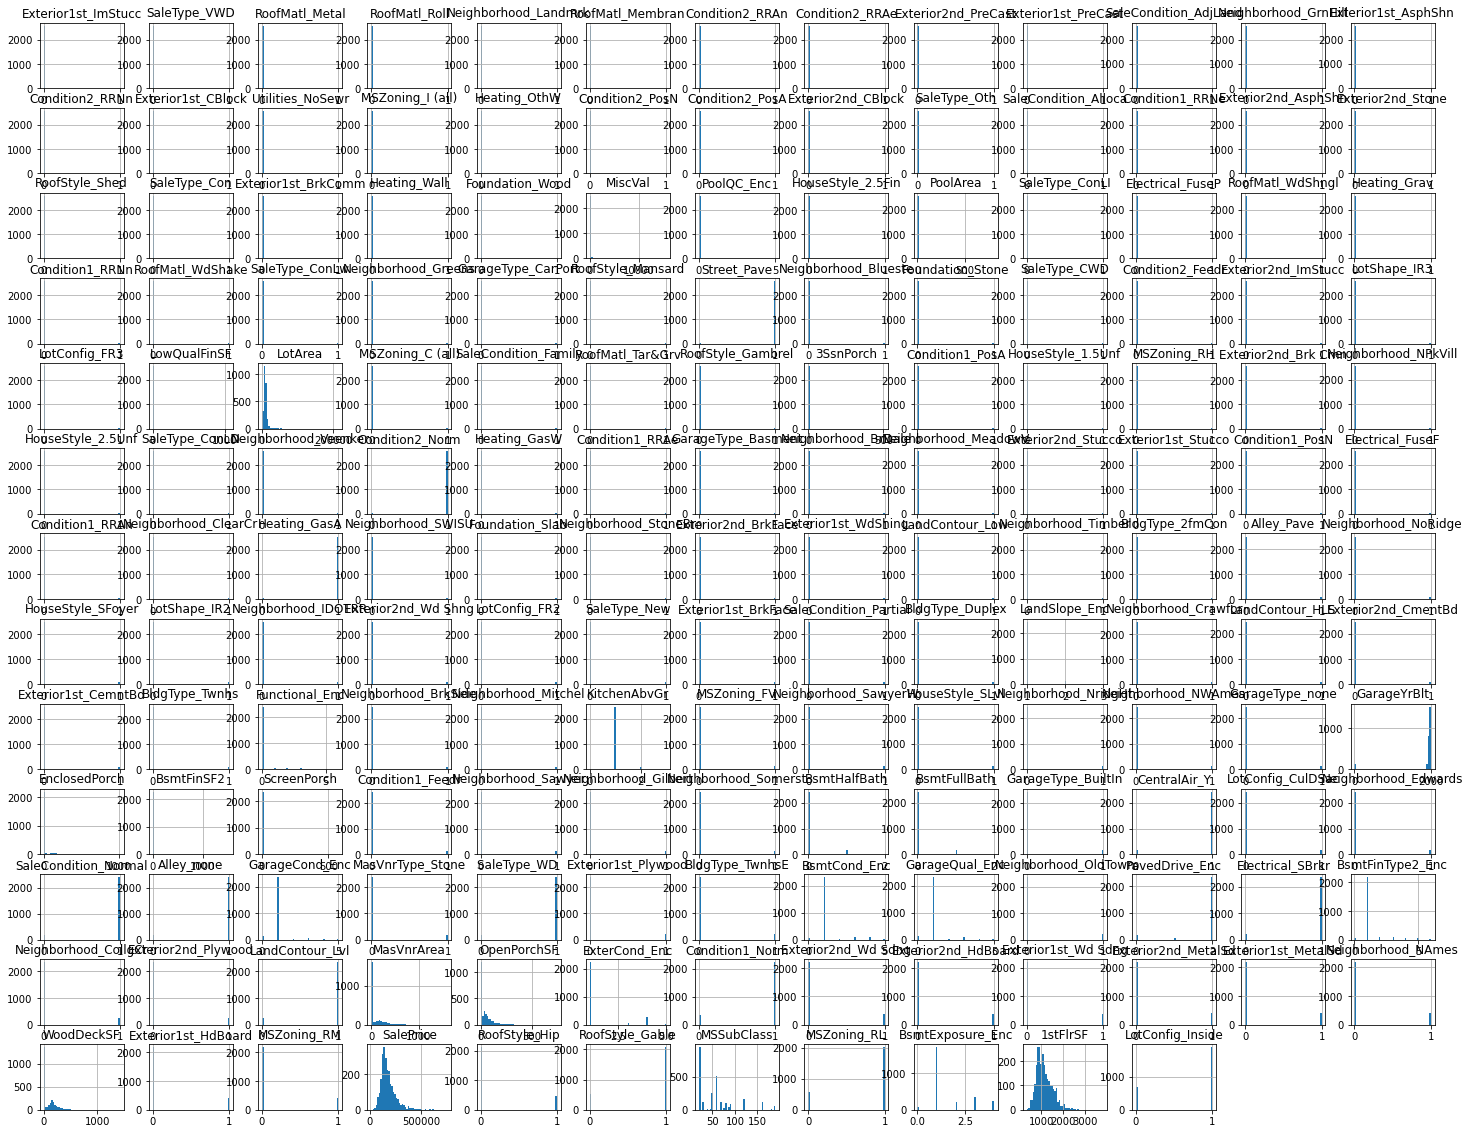

In [89]:
skewed_data.hist(bins = 50, figsize = (25,20))  ## visualization shows us most skews are zero-inflated

KeyboardInterrupt: 

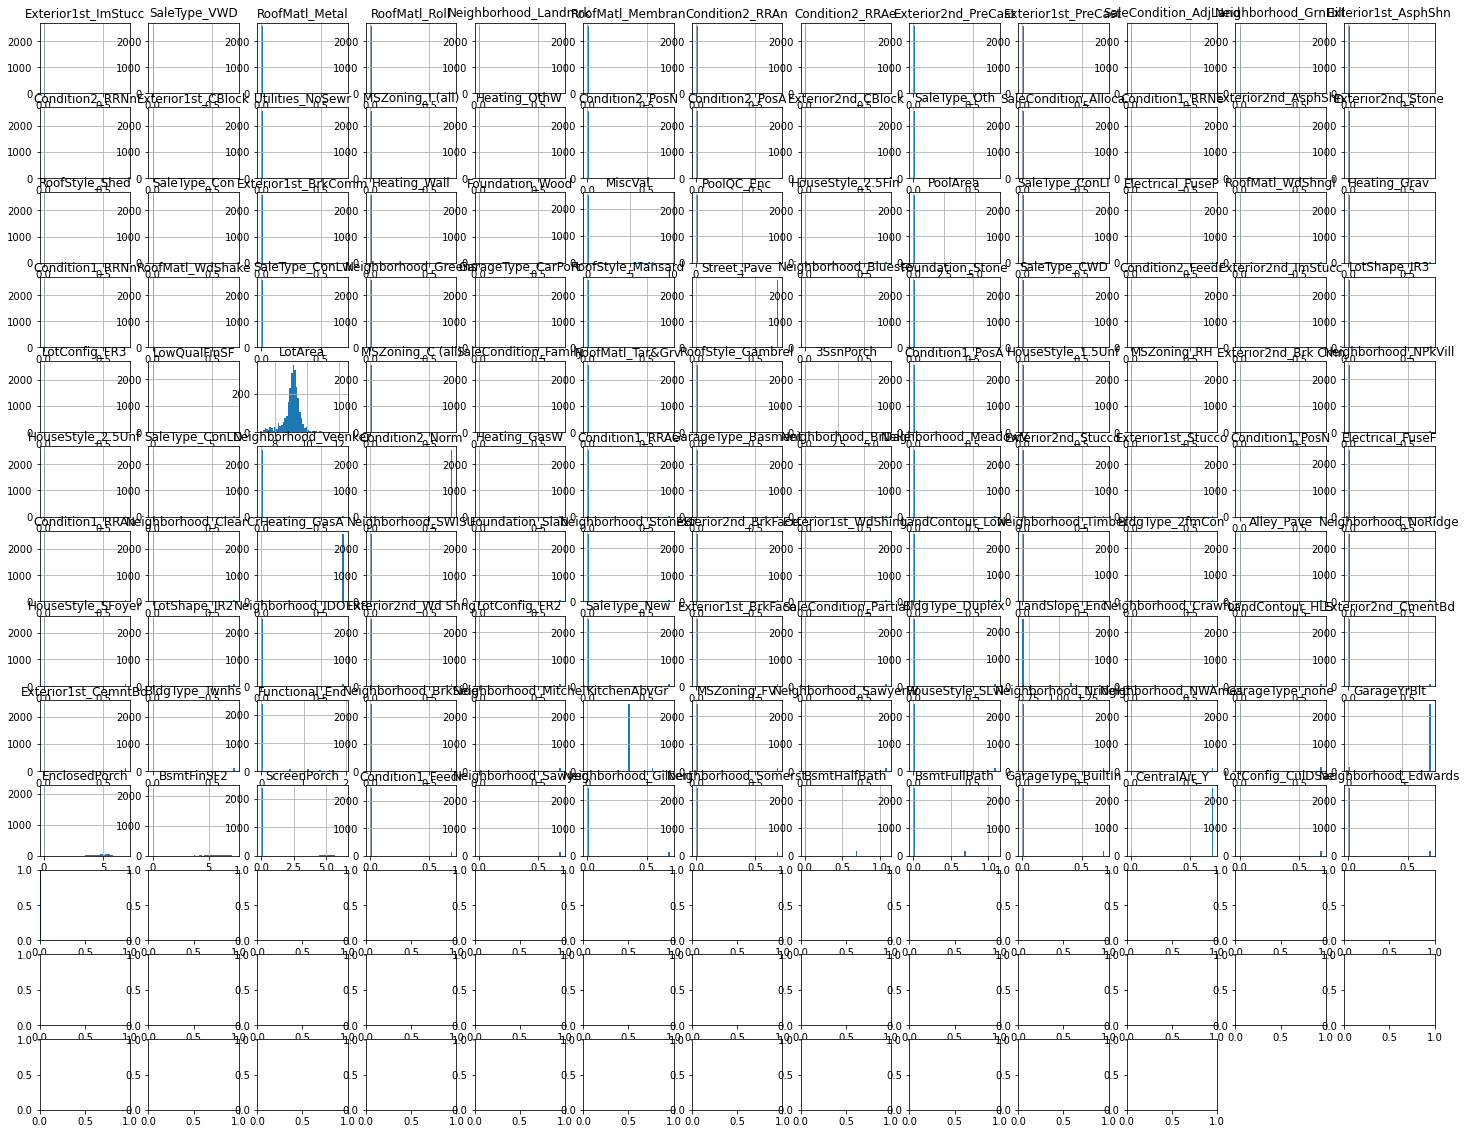

In [90]:
for feature in skewed_data.columns:
    log_skewed = boxcox1p(skewed_data, 0)
log_skewed.hist(bins = 50, figsize = (25,20))

**moderately skewed features**

In [ ]:
modSkewedFeatures = continuous.loc[continuous["AbsSkew"] > .5]
modSkewedFeatures = modSkewedFeatures.loc[modSkewedFeatures["AbsSkew"] < 1].sort_values("AbsSkew",ascending=False)
modSkewed_data = hp_num[modSkewedFeatures['Features']]

modSkewed_data.hist(bins=50, figsize=(25,25))

In [ ]:
for feature in modSkewed_data.columns:
    log_modSkewed = boxcox1p(modSkewed_data, 0)
log_modSkewed.hist(bins=50, figsize=(25,20))

In [ ]:
def skew(df):
    for feature in df.columns:
        return df.skew()

In [ ]:
# impact of log on extreme skewness 
pd.DataFrame(zip(skewed_data, skew(skewed_data),skew(log_skewed)), columns=['Features','Skew','LogSkew'])

In [ ]:
# impact of log on moderate skewness 
pd.DataFrame(zip(modSkewed_data, skew(modSkewed_data),skew(log_modSkewed)), columns=['Features','Skew','LogSkew'])

In [ ]:
log_modSkewed

In [ ]:
# inserting log of skewed to dataframe
housePrice[log_skewed.columns] = log_skewed
housePrice[log_modSkewed.columns] = log_modSkewed
housePrice

### Transform Cyclical Features with Cosine and Sine Wave
- Months are cyclical, due to seasonal changes
- A negative cosine wave (y=-cos(x)) can represent this pattern, where month 1 and month 12 are similar and start from the same point high values mean hot and low values mean cold
- $cos(x)$ and $sin(x)$
- Stored in separate set, to compare model scores to see if actually makes significant improvement 

In [ ]:
import math 
# normalize for these calculations 
housePriceCyc = housePrice
housePriceCyc["MoSold_norm"] = 2 * math.pi * housePrice["MoSold"]  / housePrice["MoSold"].max()
# assign both sine and cosine values to make sure each value has a unique 
# and still cyclical value (march and october aren't percieved as the same item)
housePriceCyc["cos_MoSold"] = np.cos( housePriceCyc["MoSold_norm"])
housePriceCyc["sin_MoSold"] = np.sin( housePriceCyc["MoSold_norm"])
housePriceCyc = housePriceCyc.drop(columns=['MoSold_norm','MoSold'])
# housePrice["sincos_MoSold"] = np.sin( housePrice["cos_MoSold"])
# housePrice.MoSold = np.cos(0.5*housePrice.MoSold)

## Train Test Split
- before standard scaler, to prevent leakage

In [ ]:
target = housePrice['SalePrice']
features = housePrice.drop(columns='SalePrice')

In [ ]:
# features with months cyclical
featuresCyc = housePriceCyc.drop(columns='SalePrice')

### Split

In [ ]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=2)

In [ ]:
# first play with Multivariate Linear Regression

from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(X_train, y_train)
print('R^2 train', ols.score(X_train, y_train))
print('R^2 test', ols.score(X_test, y_test))

#### Cyc test train split to compare
- apply to Cyc (just run this and run models again to compare numbers)

In [ ]:
X_trainCyc, X_testCyc, y_train, y_test = train_test_split(
    featuresCyc, target, test_size=0.2, random_state=0)

In [ ]:
ols = LinearRegression()  ## reeeeeally bad

ols.fit(X_trainCyc, y_train)
print('R^2 train', ols.score(X_trainCyc, y_train))
print('R^2 test', ols.score(X_testCyc, y_test))

### MinMaxScaler (to accomodate dummy variables) --- **causes really bad scores!!! not sure why...**
- fit scaler to train set (no leakage)
- apply to test

In [ ]:
# # splitting the data
# X_train, X_test, y_train, y_test = train_test_split(
#     features, target, test_size=0.2, random_state=1)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# standard scaler doesn't make sense for dummies --> switched to MinMax

# standard = standardScaler()
# standard.fit(housePriceCyc)
# housePriceCycStan = pd.DataFrame(standard.transform(housePriceCyc), index = housePriceCyc.index, columns = housePriceCyc.columns)
# housePriceCycStan

In [ ]:
# # check linear model again    ### .... also really really bad
# 
# ols = LinearRegression()
# ols.fit(X_train, y_train)
# print('R^2 train', ols.score(X_train, y_train))
# print('R^2 test', ols.score(X_test, y_test))

## K-fold Split and Cross Validation

In [ ]:
# split training data into 5 parts for cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
kfold.get_n_splits(X_train, y_train) # see that split worked

In [ ]:
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, cv=kfold)
print(scores)
np.mean(scores)

# Feature Selection
- Manual (studying correlation matrix)
- Regularization (Lasso)
- Sequential Feature Selection (Forward Stepwise)
- Filter (VIF)
- SFS and GridSearch

## Pipeline 
- Recursive Feature Elimination (RFECV)
- RandomForest
- GridSearchCV  

In [96]:
# first run pipeline on .1 sample of data to see how long gridsearch will take
X_sample = X_train.sample(50)
y_sample = y_train.sample(100)

In [95]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# random forest regression
rf_fselect = RandomForestRegressor(n_estimators=50,
                                   max_features=.1,
                                  random_state=0)
# recursive feature elimination 
rfecv = RFECV(estimator=rf_fselect,
             step=1,
             cv=5,
             scoring = 'r2')

# final regressor
rf = RandomForestRegressor(n_estimators=20,
                          random_state=0,
                          max_features = .1)

# grid rf parameters
# grid_para_forest = [{
#    "n_estimators": [25, 50, 100],
#     "criterion": ["gini", "entropy"],
#     "min_samples_leaf": range(1, 10),
#     "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
#     "random_state": [42]
# }]

gs = GridSearchCV(rf, param_grid={'max_depth':[2,3]})

pipeline = Pipeline([('featureSelection', rfecv),
                    ('randomForest_params', gs)])

%time
pipeline.fit(X_sample, y_sample)
pipeline.predict(X_sample)

# pipeline.fit(X_train, y_train)
# pipeline.predict(X_test)

Wall time: 0 ns


array([12.02554853, 11.94129492, 12.03246525, 11.94977743, 11.92611123,
       11.98956977, 11.97982016, 11.89242533, 11.99398778, 11.99687895,
       11.96429409, 12.01979387, 12.00046313, 12.04828103, 11.99817743,
       11.99407574, 11.91266467, 12.00341449, 12.06695489, 11.94156245,
       11.6114287 , 11.9899877 , 12.04074044, 12.0066935 , 11.93349346,
       11.96489704, 12.02246872, 12.05274186, 11.97585492, 12.0102494 ,
       11.97386055, 11.97327229, 11.92705351, 12.0186748 , 11.99569402,
       11.96905395, 11.91688563, 11.9914824 , 12.03192635, 11.99197128,
       11.94979811, 12.07414826, 11.97707305, 11.99223509, 11.94493564,
       11.94443566, 11.98568039, 12.04533872, 11.71040599, 11.96912399,
       12.07689191, 12.01063333, 12.02650864, 11.94437836, 12.0222444 ,
       11.9669819 , 12.0978947 , 11.88707773, 11.95632863, 12.02878667,
       11.9629358 , 12.22788726, 11.98047408, 11.96539014, 11.92916923,
       12.01071246, 11.92808578, 11.98377334, 12.10161885, 11.94

In [101]:
pipeline.score(X_test,y_test)

0.04567872640069781

#### Lasso Penalization

In [ ]:
reg = Lasso(alpha=)
reg.fit(features, target)
print('Lasso Train $R^2$:', reg.score(features, target))
print('Lasso Train $R^2$:', reg.score(features, target))

In [ ]:
lasso = Lasso()
train_R2 = []
test_R2  = []
alphaRange = np.linspace(1e-5,.01,20)
for alpha in alphaRange:
          lasso.set_params(alpha=alpha, normalize=True, max_iter=2000)  # increase the num_iter to improve convergence
          lasso.fit(X_train,y_train)
          train_R2.append(lasso.score(X_train, y_train))
          test_R2.append(lasso.score(X_test, y_test))

In [ ]:
plt.plot(alphaRange, train_R2, label=r'train $R^2$')
plt.plot(alphaRange, test_R2, label=r'test $R^2$')
plt.legend(loc=1)

In [ ]:
# no clear ideal alpha --> gridsearchCV
lasso.Coef

#### Variance Inflation Factor (VIF)

##### $ VIF = 1/(1-R^2) $

In [ ]:
# option to remove features that have high correlation/low p with target

In [ ]:
# housePrice and housePriceStan
y = pd.DataFrame(target)
X = features

In [ ]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

## alternative multipler regression method
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [ ]:
vif.sort_values('VIF',ascending=False)

In [ ]:
# explude features with severe correlation - VIF score over 5
sev_corr = vif['variable'].loc[vif['VIF'] > 5]
featuresVif = X.loc[:,~X.columns.isin(sev_corr)]
featuresVif.shape                                # stil needs to be split / kfold for cross-validation

In [ ]:
# again for standard Scaler set
y = pd.DataFrame(targetStan)
X = featuresStan

In [ ]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

## alternative multipler regression method
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [ ]:
vif.sort_values('VIF',ascending=False)

In [ ]:
# explude features with severe correlation - VIF score over 5
sev_corr = vif['variable'].loc[vif['VIF'] > 5]
featuresStanVif = X.loc[:,~X.columns.isin(sev_corr)]
featuresStanVif                             # stil needs to be split / kfold for cross-validation